# Deep Neural Networks course - assignment 1
## Michał Filipiuk 385423

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from src.batch_norm import Batch_norm_2d
from src.network import Fruit_conv_net, training, train_to_threshold
from src.data_loader import load_dataset
from src.config_loader import load_config
from src.utils import imshow

### Loading configuration and data

In [5]:
config = load_config()
torch.cuda.set_device(config["DEVICE_NUMBER"])

In [6]:
train_class_to_id, train_set_loader = load_dataset(config["DATA_PATH"] + config["TRAIN_PATH"])
test_class_to_id, test_set_loader = load_dataset(config["DATA_PATH"] + config["TEST_PATH"], batch_size=1000)

## Part 1 - network

### Training of the network

In [7]:
network = Fruit_conv_net().cuda()

In [8]:
train_to_threshold(network, train_set_loader, test_set_loader)

Training started
Epoch 0: Accuracy of the network:87.76566591559587%
Epoch 1: Accuracy of the network:95.34133122221546%
Epoch 2: Accuracy of the network:96.23652639912308%
Epoch 3: Accuracy of the network:90.54259789294197%
Epoch 4: Accuracy of the network:97.56409475671396%
Finished Training


## Part 2 - visualisation

In [9]:
train_class_to_id, train_set_loader = load_dataset(config["DATA_PATH"] + config["TRAIN_PATH"], batch_size=1)
images, labels = iter(train_set_loader).next()

### Occlusion

In [10]:
radius_of_kernel = 20
width = 100
height = 100

colours = {"R":0,"G":0,"B":0}
multiplied_images = (torch.ones([10000,1])).matmul(images.view(1,-1)).view(10000,3,100,100)  

In [11]:
for i in range(100):
    for j in range(100):
        multiplied_images[100*i+j][0][max(i-radius_of_kernel,0):min(i+radius_of_kernel,height), max(j-radius_of_kernel,0):min(j+radius_of_kernel, width)]=colours['R']
        multiplied_images[100*i+j][1][max(i-radius_of_kernel,0):min(i+radius_of_kernel,height), max(j-radius_of_kernel,0):min(j+radius_of_kernel, width)]=colours['G']
        multiplied_images[100*i+j][2][max(i-radius_of_kernel,0):min(i+radius_of_kernel,height), max(j-radius_of_kernel,0):min(j+radius_of_kernel, width)]=colours['B']

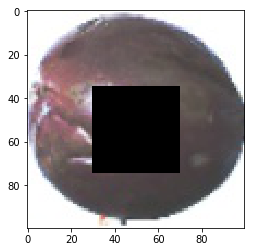

In [16]:
imshow(torchvision.utils.make_grid(multiplied_images[5550].cpu()))

In [23]:
aggregate_losses = None
labels_mult = labels.view(1,1).float().matmul(torch.ones(100).view(1,100)).view(100).long().cuda()
dataset = torch.utils.data.TensorDataset(multiplied_images)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100)
criterion = nn.CrossEntropyLoss(reduction='none')
for i, data in enumerate(data_loader, 0):
    outputs = network(data[0].cuda())
    data[0].cpu()
    loss = criterion(outputs, labels_mult)
    if aggregate_losses is None:
        aggregate_losses = loss
    else:
        aggregate_losses = torch.cat((aggregate_losses.view(-1), loss.view(-1)), 0)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


RuntimeError: CUDA out of memory. Tried to allocate 28.62 MiB (GPU 2; 11.91 GiB total capacity; 10.73 GiB already allocated; 27.12 MiB free; 433.50 MiB cached)

### Gradients

In [28]:
images_grad = torch.autograd.Variable(images, requires_grad=True)
optimizer = optim.Adam(network.parameters(), lr=0.0001, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
optimizer.zero_grad()
outputs = network(images_grad.cuda())
loss = criterion(outputs.cpu(), labels)
loss.backward()
grads = images_grad.grad

In [29]:
picture = grads.cpu()[0]
R,G,B = grads.cpu()[0]

In [30]:
globalMax = torch.max(picture)
globalMin = torch.min(picture)
globalLength = 2*torch.max(torch.abs(globalMax),torch.abs(globalMin))

In [31]:
globalMax, globalMin, globalLength

(tensor(0.0258), tensor(-0.0427), tensor(0.0854))

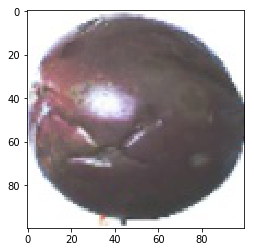

In [32]:
imshow(torchvision.utils.make_grid(images.detach().cpu()))

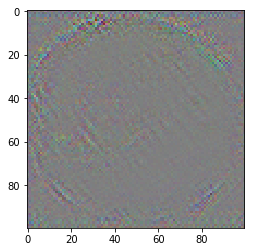

In [33]:
imshow(torchvision.utils.make_grid((picture + globalLength/2)/globalLength))

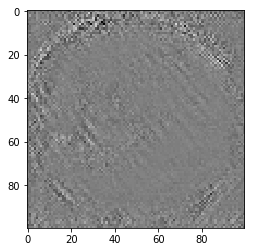

In [34]:
GMax = torch.max(G)
GMin = torch.min(G)
GLength = 2*torch.max(torch.abs(GMax),torch.abs(GMin))
imshow(torchvision.utils.make_grid((G + GLength/2)/GLength))

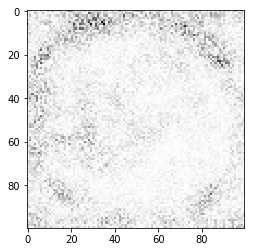

In [35]:
imshow(torchvision.utils.make_grid(1-(torch.abs(G))/GLength*2))

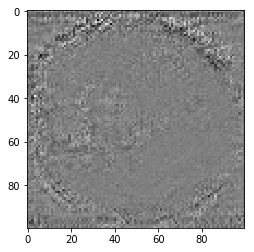

In [36]:
RMax = torch.max(R)
RMin = torch.min(R)
RLength = 2*torch.max(torch.abs(RMax),torch.abs(RMin))
imshow(torchvision.utils.make_grid((R + RLength/2)/RLength))

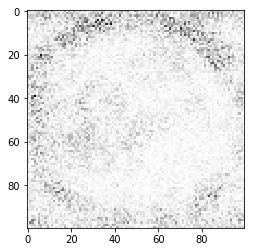

In [37]:
imshow(torchvision.utils.make_grid(1-(torch.abs(R))/RLength*2))

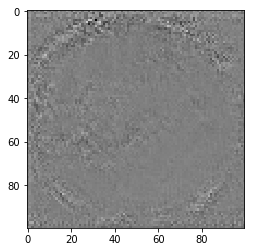

In [38]:
BMax = torch.max(B)
BMin = torch.min(B)
BLength = 2*torch.max(torch.abs(BMax),torch.abs(BMin))
imshow(torchvision.utils.make_grid((B + BLength/2)/BLength))

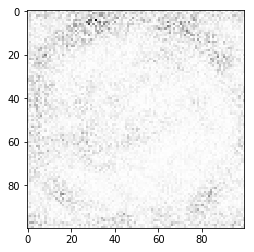

In [39]:
imshow(torchvision.utils.make_grid(1-(torch.abs(B))/BLength*2))